ML Course, Bogotá, Colombia  (&copy; Josh Bloom; June 2019)

In [2]:
%run ../talktools.py

# Featurization and Dirty Data (and NLP)

<img src="imgs/workflow.png">
Source: [V. Singh](https://www.slideshare.net/hortonworks/data-science-workshop)

<img src="imgs/feature.png">
Source: Lightsidelabs

<img src="imgs/feature2.png">

# Featurization Examples

In the real world, we are very rarely presented with a clean feature matrix. Raw data are missing, noisy, ugly and unfiltered. And sometimes we dont even have the data we need to make models and predictions.  Indeed the conversion of raw data to data that's suitable for learning on is time consuming, difficult, and where a lot of the domain understanding is required.

When we extract features from raw data (say PDF documents) we often are presented with a variety of data types:
<img src="imgs/feat.png">

# Categorical & Missing Features


Often times, we might be presented with raw data (say from an Excel spreadsheet) that looks like:

| eye color | height | country of origin | gender |
| ------------| ---------| ---------------------| ------- |
|  brown    |  1.85    |  Colombia           |     M    |
|  brown    |  1.25    |  USA                   |            |
|  blonde   |  1.45    |  Mexico               |     F     |
|  red         |  2.01    |  Mexico               |     F     |
|                |             |  Chile                   |     F     |
|  Brown   |  1.02    |  Colombia           |             |  

What do you notice in this dataset? 

Since many ML learn algorithms require, as we'll see, a full matrix of numerical input features, there's often times a lot of preprocessing work that is needed before we can learn.

In [3]:
import numpy as np
import pandas as pd

df = pd.DataFrame({"eye color": ["brown", "brown", "blonde", "red", None, "Brown"],
  "height": [1.85, 1.25, 1.45, 2.01, None, 1.02],
  "country of origin": ["Colombia", "USA", "Mexico", "Mexico", "Chile", "Colombia"],
  "gender": ["M", None, "F", "F","F", None]})
df

,country of origin,eye color,gender,height
0,Colombia,brown,M,1.85
1,USA,brown,None,1.25
2,Mexico,blonde,F,1.45
3,Mexico,red,F,2.01
4,Chile,None,F,NaN
5,Colombia,Brown,None,1.02


Let's first normalize the data so it's all lower case. This will handle the "Brown" and "brown" issue.

In [4]:
df_new = df.copy()
df_new["eye color"] = df_new["eye color"].str.lower()
df_new

,country of origin,eye color,gender,height
0,Colombia,brown,M,1.85
1,USA,brown,None,1.25
2,Mexico,blonde,F,1.45
3,Mexico,red,F,2.01
4,Chile,None,F,NaN
5,Colombia,brown,None,1.02


Let's next handle the NaN in the height. What should we use here?

In [5]:
# mean of everyone?
np.nanmean(df_new["height"].values)

1.516

In [6]:
# mean of just females?
np.nanmean(df_new[df_new["gender"] == 'F']["height"]) 

1.73

In [7]:
df_new1 = df_new.copy()
df_new1.at[4, "height"] = np.nanmean(df_new[df_new["gender"] == 'F']["height"]) 
df_new1

,country of origin,eye color,gender,height
0,Colombia,brown,M,1.85
1,USA,brown,None,1.25
2,Mexico,blonde,F,1.45
3,Mexico,red,F,2.01
4,Chile,None,F,1.73
5,Colombia,brown,None,1.02


Let's next handle the eye color. What should we use?

In [8]:
df_new1["eye color"].mode()

0    brown
dtype: object

In [9]:
df_new2 = df_new1.copy()
df_new2.at[4, "eye color"] = df_new1["eye color"].mode().values[0]
df_new2

,country of origin,eye color,gender,height
0,Colombia,brown,M,1.85
1,USA,brown,None,1.25
2,Mexico,blonde,F,1.45
3,Mexico,red,F,2.01
4,Chile,brown,F,1.73
5,Colombia,brown,None,1.02


How should we handle the missing gender entries?

In [10]:
df_new3 = df_new2.fillna("N/A")
df_new3

,country of origin,eye color,gender,height
0,Colombia,brown,M,1.85
1,USA,brown,N/A,1.25
2,Mexico,blonde,F,1.45
3,Mexico,red,F,2.01
4,Chile,brown,F,1.73
5,Colombia,brown,N/A,1.02


We're done, right? No. We fixed the dirty, missing data problem but we still dont have a numerical feature matrix.

We could do a mapping such that "Colombia" -> 1, "USA" -> 2, ... etc. but then that would imply an ordering between what is fundamentally categories (without ordering). Instead we want to do `one-hot encoding`, where every unique value gets its own column. `pandas` as a method on DataFrames called `get_dummies` which does this for us.

In [11]:
pd.get_dummies(df_new3, prefix=['country of origin', 'eye color', 'gender'])

,height,country of origin_Chile,country of origin_Colombia,country of origin_Mexico,country of origin_USA,eye color_blonde,eye color_brown,eye color_red,gender_F,gender_M,gender_N/A
0,1.85,0,1,0,0,0,1,0,0,1,0
1,1.25,0,0,0,1,0,1,0,0,0,1
2,1.45,0,0,1,0,1,0,0,1,0,0
3,2.01,0,0,1,0,0,0,1,1,0,0
4,1.73,1,0,0,0,0,1,0,1,0,0
5,1.02,0,1,0,0,0,1,0,0,0,1


Note: depending on the learning algorithm you use, you may want to do `drop_first=True` in `get_dummies`.

Of course there are helpful tools that exist for us to deal with dirty, missing data.

In [12]:
%run transform

In [13]:
bt = BasicTransformer(return_df=True)
bt.fit_transform(df_new)

,height,country of origin_Mexico,country of origin_Colombia,country of origin_Chile,country of origin_USA,eye color_brown,eye color_red,eye color_blonde,gender_F,gender_M
0,0.935272,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-0.691288,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,-0.149101,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,1.369021,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,-0.149101,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5,-1.314803,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Time series

The [wafer dataset](http://www.timeseriesclassification.com/description.php?Dataset=Wafer) is a set of timeseries capturing sensor measurements (1000 training examples, 6164 test examples) of one silicon wafer during the manufacture of semiconductors. Each wafer has a classification of normal or abnormal. The abnormal wafers are representative of a range of problems commonly encountered during semiconductor manufacturing.

In [14]:
import requests
from io import StringIO
dat_file = requests.get("https://github.com/zygmuntz/time-series-classification/blob/master/data/wafer/Wafer.csv?raw=true")
data = StringIO(dat_file.text)

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
data.seek(0)
df = pd.read_csv(data, header=None)

In [16]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,143,144,145,146,147,148,149,150,151,152
0,1.01430,1.0143,1.01430,1.01430,1.01430,1.0143,1.01430,1.01430,1.01430,1.0143,...,1.01430,1.01430,1.014300,1.014300,1.014300,1.014300,1.014300,1.014300,1.01430,1
1,-0.88485,-1.0375,-0.97771,-1.01690,-0.98675,-1.0107,-0.98142,-1.01920,-0.96448,-1.0542,...,-1.00060,-0.99919,-1.002200,-0.997130,-1.005200,-0.992500,-1.012500,-0.980370,-1.03760,-1
2,0.58040,0.5804,0.59777,0.59777,0.58040,0.5804,0.59777,0.58040,0.58040,0.5804,...,0.42407,0.40670,0.389330,0.371960,0.354590,0.337220,0.319860,0.302490,0.28512,1
3,-0.88390,-1.0371,-0.97998,-1.01210,-0.99210,-1.0048,-1.00040,-0.99608,-1.01120,-0.9817,...,-1.00020,-0.99878,-1.001800,-0.996730,-1.004800,-0.992100,-1.012100,-0.979980,-1.03710,-1
4,1.10500,1.2856,1.19630,1.25610,1.21950,1.2133,1.21540,1.22240,1.23160,1.2081,...,0.14516,0.11434,0.083001,0.052635,0.020452,-0.008753,-0.042507,-0.069158,-0.10816,-1


In [17]:
df[152].value_counts()

 1    6402
-1     762
Name: 152, dtype: int64

In [18]:
## save the data as numpy arrays
target = df.values[:,152].astype(int)
time_series = df.values[:,0:152]

Text(0, 0.5, 'Value')

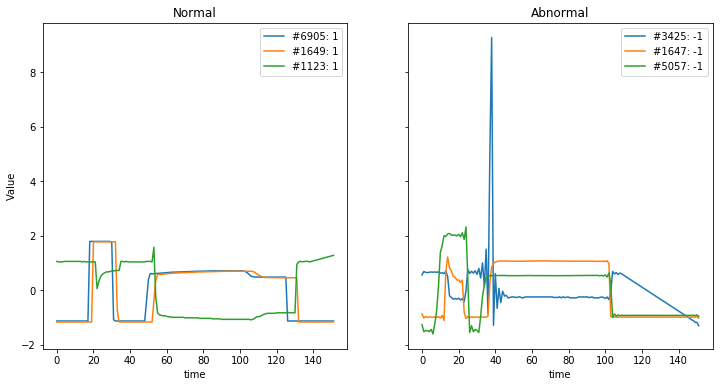

In [19]:
normal_inds = np.argwhere(target == 1) ; np.random.shuffle(normal_inds)
abnormal_inds = np.argwhere(target == -1); np.random.shuffle(abnormal_inds)

num_to_plot = 3
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12,6))

for i in range(num_to_plot):
    ax1.plot(time_series[normal_inds[i][0],:], label=f"#{normal_inds[i][0]}: {target[normal_inds[i][0]]}")
    ax2.plot(time_series[abnormal_inds[i][0],:], label=f"#{abnormal_inds[i][0]}: {target[abnormal_inds[i][0]]}")

ax1.legend()
ax2.legend()
ax1.set_title("Normal") ; ax2.set_title("Abnormal") 
ax1.set_xlabel("time") ; ax2.set_xlabel("time")
ax1.set_ylabel("Value")

What would be good features here?

In [20]:
f1 = np.mean(time_series, axis=1)  # how about the mean?
f1.shape

(7164,)

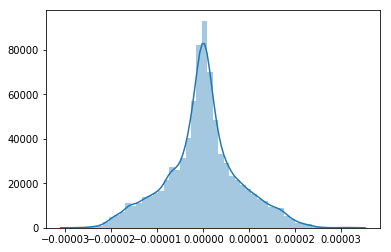

In [21]:
import seaborn as sns, numpy as np
import warnings
warnings.filterwarnings("ignore")

ax = sns.distplot(f1)

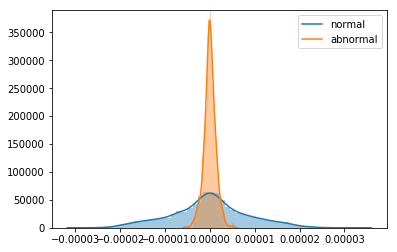

In [22]:
ax = sns.distplot(f1[normal_inds], kde_kws={"label": "normal"})
sns.distplot(f1[abnormal_inds], ax=ax, kde_kws={"label": "abnormal"})

In [23]:
f2 = np.min(time_series, axis=1)  # how about the mean?
f2.shape

(7164,)

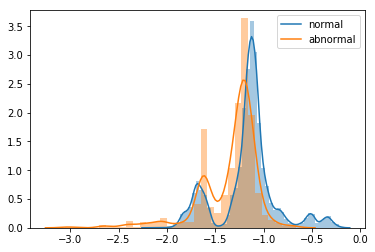

In [24]:
ax = sns.distplot(f2[normal_inds], kde_kws={"label": "normal"})
sns.distplot(f2[abnormal_inds], ax=ax, kde_kws={"label": "abnormal"})

Often there are entire python packages devoted to help us build features from certain types of datasets (timeseries, text, images, movies, etc.). In the case of timeseries, a popular package is `tsfresh` (*"It automatically calculates a large number of time series characteristics, the so called features. Further the package contains methods to evaluate the explaining power and importance of such characteristics for regression or classification tasks."*). See the [tsfresh docs](https://tsfresh.readthedocs.io/en/latest/) and the [list of features generated](https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html).

In [25]:
# !pip install tsfresh

In [26]:
dfc = df.copy()
del dfc[152]
d = dfc.stack()
d = d.reset_index()
d = d.rename(columns={"level_0": "id", "level_1": "time", 0: "value"})
y = df[152]

In [27]:
from tsfresh import extract_features

max_num=300

from tsfresh import extract_relevant_features

features_filtered_direct = extract_relevant_features(d[d["id"] < max_num], y.iloc[0:max_num],
                                                     column_id='id', column_sort='time', n_jobs=4)
#extracted_features = extract_features(, column_id="id", 
 #                                                           column_sort="time", disable_progressbar=False, n_jobs=3)

Feature Extraction: 100%|██████████| 20/20 [00:21<00:00,  1.08s/it]
 'value__fft_coefficient__coeff_77__attr_"angle"'
 'value__fft_coefficient__coeff_77__attr_"imag"'
 'value__fft_coefficient__coeff_77__attr_"real"'
 'value__fft_coefficient__coeff_78__attr_"abs"'
 'value__fft_coefficient__coeff_78__attr_"angle"'
 'value__fft_coefficient__coeff_78__attr_"imag"'
 'value__fft_coefficient__coeff_78__attr_"real"'
 'value__fft_coefficient__coeff_79__attr_"abs"'
 'value__fft_coefficient__coeff_79__attr_"angle"'
 'value__fft_coefficient__coeff_79__attr_"imag"'
 'value__fft_coefficient__coeff_79__attr_"real"'
 'value__fft_coefficient__coeff_80__attr_"abs"'
 'value__fft_coefficient__coeff_80__attr_"angle"'
 'value__fft_coefficient__coeff_80__attr_"imag"'
 'value__fft_coefficient__coeff_80__attr_"real"'
 'value__fft_coefficient__coeff_81__attr_"abs"'
 'value__fft_coefficient__coeff_81__attr_"angle"'
 'value__fft_coefficient__coeff_81__attr_"imag"'
 'value__fft_coefficient__coeff_81__attr_"real"'


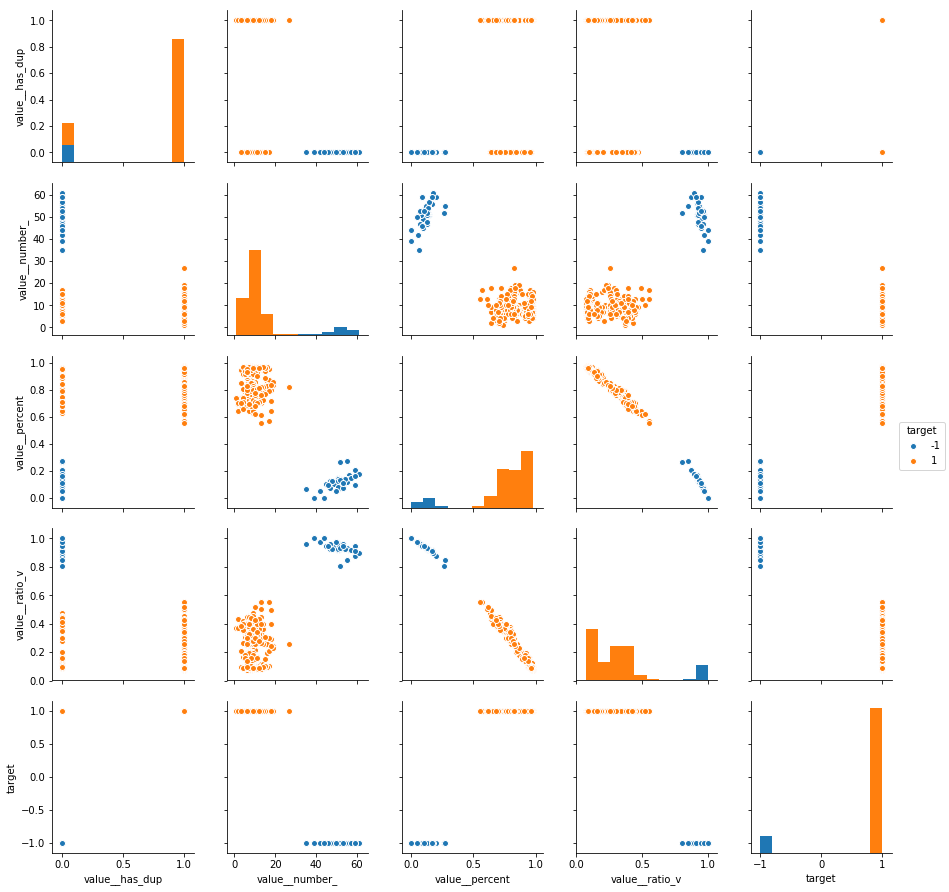

In [28]:
feats = features_filtered_direct[features_filtered_direct.columns[0:4]].rename(lambda x: x[0:14], axis='columns')
feats["target"] = y.iloc[0:max_num]
sns.pairplot(feats, hue="target")

# Text Data

Many applications involve parsing and understanding something about natural language, ie. speech or text data.  Categorization is a classic usage of Natural Language Processing (NLP): what bucket does this text belong to? 

Question: **What are some examples where learning on text has commerical or industrial applications?**

A classic dataset in text processing is the [20,000+ newsgroup documents corpus](http://qwone.com/~jason/20Newsgroups/). These texts taken from old discussion threads in 20 different [newgroups](https://en.wikipedia.org/wiki/Usenet_newsgroup):

<pre>
comp.graphics
comp.os.ms-windows.misc
comp.sys.ibm.pc.hardware
comp.sys.mac.hardware
comp.windows.x	
rec.autos
rec.motorcycles
rec.sport.baseball
rec.sport.hockey	
sci.crypt
sci.electronics
sci.med
sci.space
misc.forsale	
talk.politics.misc
talk.politics.guns
talk.politics.mideast	
talk.religion.misc
alt.atheism
soc.religion.christian
</pre>
One of the tasks is to assign a document to the correct group, ie. classify which group this belongs to. `sklearn` has a download facility for this dataset:

In [29]:
from sklearn.datasets import fetch_20newsgroups
news_train = fetch_20newsgroups(subset='train', categories=['sci.space','rec.autos'], data_home='datatmp/')

In [30]:
news_train.target_names

['rec.autos', 'sci.space']

In [31]:
print(news_train.data[1])

From: smith@ctron.com (Lawrence C Smith)
Subject: Re: MR2 - noisy engine.
Organization: Cabletron Systems, Inc.
Lines: 16
Distribution: world
Reply-To: smith@ctron.com
NNTP-Posting-Host: glinda.ctron.com

In article <Apr21.053718.19765@engr.washington.edu>, eliot@lanmola.engr.washington.edu (eliot) writes:

>if the noise really bugs you, there is nothing else that you can do
>except to sell it and get a V6.

Perhaps a nice used '88 Pontiac Fiero GT?  2.8 liters.

Does anyone know if the motor mounts for the 2.8 and the twin-dual-cam 3.4
liter match?  The 3.4 is supposedly derived from the pushrod 3.1, which was
a punched out 2.8 liter.  Should be a drop-in replacement, eh?  205 horses in
a mid-engine the size of a Fiero?

Larry Smith (smith@ctron.com)  No, I don't speak for Cabletron.  Need you ask?
-
Liberty is not the freedom to do whatever we want,
it is the freedom to do whatever we are able.



In [32]:
news_train.target_names[news_train.target[1]]

'rec.autos'

In [33]:
autos = np.argwhere(news_train.target == 1) 
sci = np.argwhere(news_train.target == 0)

**How do you (as a human) classify text? What do you look for? How might we make these features?**

In [34]:
# total character count?
f1 = np.array([len(x) for x in news_train.data])
f1

array([ 676,  910,  756, ..., 1433,  413,  602])

Text(0.5, 0, 'number of charaters')

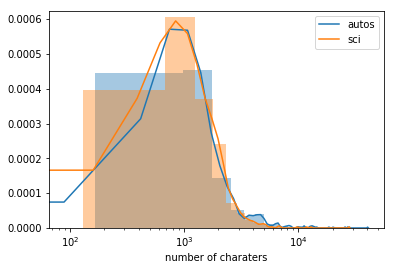

In [35]:
ax = sns.distplot(f1[autos], kde_kws={"label": "autos"})
sns.distplot(f1[sci], ax=ax, kde_kws={"label": "sci"})
ax.set_xscale("log")
ax.set_xlabel("number of charaters")

In [36]:
# total character words?
f2 = np.array([len(x.split(" ")) for x in news_train.data])
f2

array([112, 130, 110, ..., 205,  59,  79])

Text(0.5, 0, 'number of words')

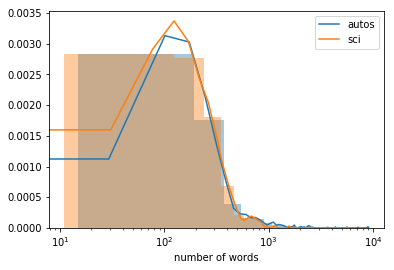

In [37]:
ax = sns.distplot(f2[autos], kde_kws={"label": "autos"})
sns.distplot(f2[sci], ax=ax, kde_kws={"label": "sci"})
ax.set_xscale("log")
ax.set_xlabel("number of words")

In [38]:
# number of questions asked or exclaimations?
f3 = np.array([x.count("?") + x.count("!") for x in news_train.data])
f3

array([4, 5, 4, ..., 2, 1, 0])

Text(0.5, 0, 'number of questions asked')

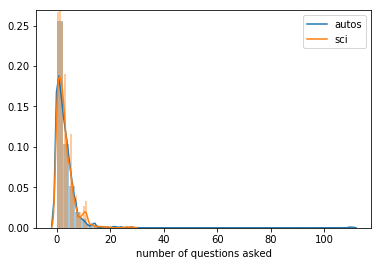

In [39]:
ax = sns.distplot(f3[autos], kde_kws={"label": "autos"})
sns.distplot(f3[sci], ax=ax, kde_kws={"label": "sci"})
ax.set_xlabel("number of questions asked")

We've got three fairly uninformative features now. We should be able to do better. 
Unsurprisingly, what matters most in NLP is the content: the words used, the tone, the meaning from the ordering of those words. The basic components of NLP are:

 * Tokenization - intelligently splitting up words in sentences, paying attention to conjunctions, punctuation, etc.
 * Lemmization - reducing a word to its base form
 * Entity recognition - finding proper names, places, etc. in documents
 
There a many Python packages that help with NLP, including `nltk`, `textblob`, `gensim`, etc. Here we'll use the fairly modern and battletested [`spaCy`](https://spacy.io/).

In [ ]:
#!pip install spacy

In [ ]:
#!python -m spacy download en

In [ ]:
#!python -m spacy download es

In [56]:
import spacy

# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load("en")

# the spanish model is
# nlp = spacy.load("es")

doc = nlp(u"Guido said that 'Python is one of the best languages for doing Data Science.' "
                   "Why he said that should be clear to anyone who knows Python.")
en_doc = doc

`doc` is now an `iterable ` with each word/item properly tokenized and tagged.  This is done by applying rules specific to each language.  Linguistic annotations are available as Token attributes.

In [41]:
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)

Guido Guido PROPN NNP nsubj Xxxxx True False
said say VERB VBD ROOT xxxx True False
that that ADP IN mark xxxx True True
' ' PUNCT `` punct ' False False
Python Python PROPN NNP nsubj Xxxxx True False
is be VERB VBZ ccomp xx True True
one one NUM CD attr xxx True True
of of ADP IN prep xx True True
the the DET DT det xxx True True
best good ADJ JJS amod xxxx True False
languages language NOUN NNS pobj xxxx True False
for for ADP IN prep xxx True True
doing do VERB VBG pcomp xxxx True True
Data Data PROPN NNP compound Xxxx True False
Science Science PROPN NNP dobj Xxxxx True False
. . PUNCT . punct . False False
' ' PUNCT '' punct ' False False
Why why ADV WRB advmod Xxx True True
he -PRON- PRON PRP nsubj xx True True
said say VERB VBD ROOT xxxx True False
that that DET DT nsubj xxxx True True
should should VERB MD aux xxxx True True
be be VERB VB ccomp xx True True
clear clear ADJ JJ acomp xxxx True False
to to ADP IN prep xx True True
anyone anyone NOUN NN pobj xxxx True True
who who 

In [42]:
from spacy import displacy

displacy.serve(doc, style="dep")


Using the 'dep' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


In [43]:
displacy.render(doc, style = "ent", jupyter = True)

In [44]:
nlp = spacy.load("es")

In [45]:
# https://www.elespectador.com/noticias/ciencia/decenas-de-nuevas-supernovas-ayudaran-medir-la-expansion-del-universo-articulo-863683
doc = nlp(u'En los últimos años, los investigadores comenzaron a'
                   'informar un nuevo tipo de supernovas de cinco a diez veces'
                   'más brillantes que las supernovas de Tipo "IA". ')

In [46]:
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)

En En ADP ADP__AdpType=Prep case Xx True True
los lo DET DET__Definite=Def|Gender=Masc|Number=Plur|PronType=Art det xxx True True
últimos último ADJ ADJ__Gender=Masc|Number=Plur|NumType=Ord amod xxxx True True
años año NOUN NOUN__Gender=Masc|Number=Plur obl xxxx True False
, , PUNCT PUNCT__PunctType=Comm punct , False False
los lo DET DET__Definite=Def|Gender=Masc|Number=Plur|PronType=Art det xxx True True
investigadores investigador NOUN NOUN__Gender=Masc|Number=Plur nsubj xxxx True False
comenzaron comenzar AUX AUX__Mood=Ind|Number=Plur|Person=3|Tense=Past|VerbForm=Fin aux xxxx True False
ainformar ainformar VERB VERB__VerbForm=Inf ROOT xxxx True False
un uno DET DET__Definite=Ind|Gender=Masc|Number=Sing|PronType=Art det xx True True
nuevo nuevo ADJ ADJ__Gender=Masc|Number=Sing amod xxxx True True
tipo tipo NOUN NOUN__Gender=Masc|Number=Sing obj xxxx True False
de de ADP ADP__AdpType=Prep case xx True True
supernovas supernova NOUN NOUN__Gender=Fem|Number=Plur nmod xxxx True False
de

In [47]:
from spacy import displacy

displacy.serve(doc, style="dep")


Using the 'dep' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


In [48]:
[i for i in doc.sents]

[En los últimos años, los investigadores comenzaron ainformar un nuevo tipo de supernovas de cinco a diez vecesmás brillantes que las supernovas de Tipo "IA".]

One very powerful way to featurize text/documents is to count the frequency of words---this is called **bag of words**. Each individual token occurrence frequency is used to generate a feature. So the two sentences become:

```json
{"Guido": 1,
  "said": 2,
  "that": 2,
  "Python": 2,
  "is": 1,
  "one": 1,
  "of": 1,
  "best": 1,
  "languages": 1,
  "for": 1,
  "Data": 1,
  "Science": 1,
  "Why", 1,
  "he": 1,
  "should": 1,
  "be": 1,
  "anyone": 1,
  "who": 1
 }
 ```


A corpus of documents can be represented as a matrix with one row per document and one column per token.

Question: **What are some challenges you see with brute force BoW?**

In [49]:
from spacy.lang.en.stop_words import STOP_WORDS
STOP_WORDS

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'fron

`sklearn` has a number of helper functions, include the [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html):

> Convert a collection of text documents to a matrix of token counts. This implementation produces a sparse representation of the counts using `scipy.sparse.csr_matrix`.

In [50]:
# the following is from https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

In [51]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

In [57]:
X = bow_vector.fit_transform([x.text for x in en_doc.sents])

In [58]:
X

<2x7 sparse matrix of type '<class 'numpy.int64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [59]:
bow_vector.get_feature_names()

['clear', 'datum', 'guido', 'know', 'language', 'python', 'science']

Why did we get `datum` as one of our feature names?

In [60]:
X.toarray()

array([[0, 1, 1, 0, 1, 1, 1],
       [1, 0, 0, 1, 0, 1, 0]], dtype=int64)

In [61]:
doc.text

"Guido said that 'Python is one of the best languages for doing Data Science.' Why he said that should be clear to anyone who knows Python."

Let's try a bigger corpus (the newsgroups):

In [62]:
news_train = fetch_20newsgroups(subset='train', 
                                                        remove=('headers', 'footers', 'quotes'),
                                                        categories=['sci.space','rec.autos'], data_home='datatmp/')

In [63]:
%time X = bow_vector.fit_transform(news_train.data)

CPU times: user 2.09 s, sys: 13.9 ms, total: 2.1 s
Wall time: 2.1 s


In [64]:
X

<1187x15001 sparse matrix of type '<class 'numpy.int64'>'
	with 67552 stored elements in Compressed Sparse Row format>

In [65]:
bow_vector.get_feature_names()

['"titanium',
 "''",
 "'89",
 "'em",
 '(-:',
 '*never',
 '*sigh*',
 '+02:21',
 '+03:11',
 '+03:18',
 '+04:10',
 '+05:21',
 '+05:26',
 '+1',
 '+13.6',
 '+14.2',
 '+15.4',
 '+16.2',
 '+16.3',
 '+17:30',
 '+19:56',
 '+22.7',
 '+22:36',
 '+24:26',
 '+2800',
 '+28:47',
 '+3.7',
 '+4.7',
 '+49',
 '--',
 '---',
 '----',
 '-----',
 '------',
 '-------',
 '--------',
 '---------',
 '-----------',
 '------------',
 '--------------',
 '----------------',
 '-----------------',
 '-------------------',
 '--------------------',
 '----------------------',
 '-----------------------',
 '-------------------------',
 '---------------------------',
 '----------------------------',
 '--------------------------------',
 '--------------------------------+---------------------------------------',
 '---------------------------------',
 '---------------------------------------------',
 '-------------------------------------------------------------',
 '-------------------------------------------------------------

Most of those features will only appear once and we might not want to include them (as they add noise). In order to reweight the count features into floating point values suitable for usage by a classifier it is very common to use the *tf–idf* transform. 

From [`sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer): 

> Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency. This is a common term weighting scheme in information retrieval, that has also found good use in document classification.
The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.


Let's keep only those terms that show up in at least 3% of the docs, but not those that show up in more than 90%.

In [66]:
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer, min_df=0.03, max_df=0.9, max_features=1000)

In [67]:
%time X = tfidf_vector.fit_transform(news_train.data)

CPU times: user 1.53 s, sys: 8.19 ms, total: 1.54 s
Wall time: 1.54 s


In [68]:
tfidf_vector.get_feature_names()

['--',
 '..',
 '...',
 '....',
 '1',
 '10',
 '15',
 '1993',
 '2',
 '20',
 '3',
 '30',
 '4',
 '5',
 '50',
 '6',
 '60',
 ':-)',
 'able',
 'actually',
 'add',
 'address',
 'ago',
 'air',
 'allow',
 'answer',
 'april',
 'area',
 'article',
 'ask',
 'assume',
 'auto',
 'available',
 'away',
 'bad',
 'base',
 'believe',
 'big',
 'bite',
 'body',
 'book',
 'bring',
 'build',
 'buy',
 'car',
 'carry',
 'case',
 'cause',
 'center',
 'change',
 'cheap',
 'check',
 'close',
 'come',
 'commercial',
 'company',
 'consider',
 'control',
 'cost',
 'couple',
 'course',
 'cover',
 'current',
 'cut',
 'date',
 'datum',
 'day',
 'deal',
 'dealer',
 'design',
 'detail',
 'development',
 'difference',
 'different',
 'doe',
 'drive',
 'driver',
 'e',
 'early',
 'earth',
 'easy',
 'email',
 'end',
 'engine',
 'engineer',
 'etc',
 'exactly',
 'example',
 'exist',
 'expect',
 'expensive',
 'experience',
 'fact',
 'far',
 'fast',
 'feel',
 'field',
 'figure',
 'find',
 'flight',
 'fly',
 'follow',
 'force',
 'f

In [69]:
X

<1187x299 sparse matrix of type '<class 'numpy.float64'>'
	with 20972 stored elements in Compressed Sparse Row format>

In [70]:
print(X[1,:])

  (0, 282)	0.25264664433284
  (0, 182)	0.44889378780494893
  (0, 74)	0.31784760138938223
  (0, 138)	0.25772936628163756
  (0, 83)	0.3573749506148357
  (0, 242)	0.44371077138978526
  (0, 179)	0.3115081012023542
  (0, 29)	0.3815483132390864


In [71]:
y = news_train.target
np.savez("tfidf.npz", X=X.todense(), y=y)

One of the challenges with BoW and TF-IDF is that we lose context. "Me gusta esta clase, no" is the same as "No me gusta esta clase". 

One way to handle this is with N-grams -- not just frequencies of individual words but of groupings of n-words. Eg. "Me guesta", "guest esta", "esta clase", "clase no", "no me" (bigrams). 

In [72]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,2))
X = bow_vector.fit_transform([x.text for x in en_doc.sents])
bow_vector.get_feature_names()

['clear',
 'clear know',
 'datum',
 'datum science',
 'guido',
 'guido python',
 'know',
 'know python',
 'language',
 'language datum',
 'python',
 'python language',
 'science']

As we'll see later in the week, while bigram TF-IDF certainly works to capture some small scale meaning, `word embeddings` tend to do very well.